# ทดสอบรวมฝนรายชั่วโมงเป็นฝนรายวัน ใช้คอลัมน์ full_date และ code พลอต density ใช้ ZR SDC

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import linregress
from scipy.stats import gaussian_kde
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


## read cleansing 

In [2]:
df = pd.read_csv('./00Results/00rain_radar_hourly_extracted_all_events_mean_dBZ/df_org_dbz_rain_test120km.csv')
#df = pd.read_csv('./00Results/00rain_radar_hourly_extracted_all_events/df_org_dbz_rain_test200km.csv')
df.drop(df[df['cappi4km'] < 10].index, inplace = True) #ฝนอ่่อนมากๆ < 10 dBZ
df.drop(df[df['cappi4km'] > 55].index, inplace = True) #ค่าการสะท้อนที่อาจเป็นลูกเห็บ 55 dBZ มุมยกด้านบนสุด
df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df
#df.head()

,cappi1km,cappi2km,cappi3km,cappi4km,full_date,code,rain_x
0,24.691301,24.196701,20.083112,20.643747,2018-06-01-00:00,CMSG,0.0
1,25.330028,23.526070,23.449750,24.210546,2018-06-01-00:00,KGTP,0.0
2,27.172401,27.172401,27.172403,27.172401,2018-06-01-00:00,LPLE,0.0
3,22.804799,24.250445,26.664243,27.962598,2018-06-01-00:00,NAN011,0.0
4,20.640297,20.409634,19.715693,19.201311,2018-06-01-00:00,SLBC,0.0
...,...,...,...,...,...,...,...
8656,16.701266,15.322284,13.358064,12.000171,2018-09-21-16:00,TPKO,0.0
8657,24.601331,24.696486,24.310151,23.377122,2018-09-21-17:00,CNDN,0.2
8658,32.678558,31.940033,31.637293,30.511404,2018-09-21-17:00,NAN005,0.0
8659,26.931454,26.879102,18.453910,23.309853,2018-09-21-17:00,NGBA,0.0


### เปลี่ยนชื่อคอลัมน์

In [3]:
df.rename(columns={"cappi1km": "dBZ_c1", "cappi2km": "dBZ_c2","cappi3km": "dBZ_c3","cappi4km": "dBZ_c4"}, inplace=True)
df.rename(columns={"rain_x":"rain_truth"}, inplace=True)
df

,dBZ_c1,dBZ_c2,dBZ_c3,dBZ_c4,full_date,code,rain_truth
0,24.691301,24.196701,20.083112,20.643747,2018-06-01-00:00,CMSG,0.0
1,25.330028,23.526070,23.449750,24.210546,2018-06-01-00:00,KGTP,0.0
2,27.172401,27.172401,27.172403,27.172401,2018-06-01-00:00,LPLE,0.0
3,22.804799,24.250445,26.664243,27.962598,2018-06-01-00:00,NAN011,0.0
4,20.640297,20.409634,19.715693,19.201311,2018-06-01-00:00,SLBC,0.0
...,...,...,...,...,...,...,...
8656,16.701266,15.322284,13.358064,12.000171,2018-09-21-16:00,TPKO,0.0
8657,24.601331,24.696486,24.310151,23.377122,2018-09-21-17:00,CNDN,0.2
8658,32.678558,31.940033,31.637293,30.511404,2018-09-21-17:00,NAN005,0.0
8659,26.931454,26.879102,18.453910,23.309853,2018-09-21-17:00,NGBA,0.0


### คำนวน rain estimates จาก ZRs

In [4]:
### ZR Summer Deep Convection
a=300. 
b=1.4
df['rr_SC_c1']=((10**(df['dBZ_c1']/10.))/a)**(1/b)
df['rr_SC_c2']=((10**(df['dBZ_c2']/10.))/a)**(1/b)
df['rr_SC_c3']=((10**(df['dBZ_c3']/10.))/a)**(1/b)
df['rr_SC_c4']=((10**(df['dBZ_c4']/10.))/a)**(1/b)
df

,dBZ_c1,dBZ_c2,dBZ_c3,dBZ_c4,full_date,code,rain_truth,rr_SC_c1,rr_SC_c2,rr_SC_c3,rr_SC_c4
0,24.691301,24.196701,20.083112,20.643747,2018-06-01-00:00,CMSG,0.0,0.986943,0.909837,0.462525,0.507202
1,25.330028,23.526070,23.449750,24.210546,2018-06-01-00:00,KGTP,0.0,1.096265,0.814819,0.804655,0.911911
2,27.172401,27.172401,27.172403,27.172401,2018-06-01-00:00,LPLE,0.0,1.484272,1.484272,1.484272,1.484272
3,22.804799,24.250445,26.664243,27.962598,2018-06-01-00:00,NAN011,0.0,0.723672,0.917915,1.365263,1.690270
4,20.640297,20.409634,19.715693,19.201311,2018-06-01-00:00,SLBC,0.0,0.506914,0.488044,0.435403,0.400083
...,...,...,...,...,...,...,...,...,...,...,...
8656,16.701266,15.322284,13.358064,12.000171,2018-09-21-16:00,TPKO,0.0,0.265201,0.211386,0.153029,0.122400
8657,24.601331,24.696486,24.310151,23.377122,2018-09-21-17:00,CNDN,0.2,0.972446,0.987785,0.926973,0.795101
8658,32.678558,31.940033,31.637293,30.511404,2018-09-21-17:00,NAN005,0.0,3.671220,3.251312,3.093387,2.570477
8659,26.931454,26.879102,18.453910,23.309853,2018-09-21-17:00,NGBA,0.0,1.426602,1.414372,0.353805,0.786352


In [5]:
## ดรอปคอมลัมน์ cappi ทิ้ง
df.drop(columns=['dBZ_c1','dBZ_c2','dBZ_c3','dBZ_c4'], inplace=True) #ลบคอลัน์
df

,full_date,code,rain_truth,rr_SC_c1,rr_SC_c2,rr_SC_c3,rr_SC_c4
0,2018-06-01-00:00,CMSG,0.0,0.986943,0.909837,0.462525,0.507202
1,2018-06-01-00:00,KGTP,0.0,1.096265,0.814819,0.804655,0.911911
2,2018-06-01-00:00,LPLE,0.0,1.484272,1.484272,1.484272,1.484272
3,2018-06-01-00:00,NAN011,0.0,0.723672,0.917915,1.365263,1.690270
4,2018-06-01-00:00,SLBC,0.0,0.506914,0.488044,0.435403,0.400083
...,...,...,...,...,...,...,...
8656,2018-09-21-16:00,TPKO,0.0,0.265201,0.211386,0.153029,0.122400
8657,2018-09-21-17:00,CNDN,0.2,0.972446,0.987785,0.926973,0.795101
8658,2018-09-21-17:00,NAN005,0.0,3.671220,3.251312,3.093387,2.570477
8659,2018-09-21-17:00,NGBA,0.0,1.426602,1.414372,0.353805,0.786352


### รวมฝนรายชั่วโมงเป็นรายวัน ด้วยการสร้างคอลัมน์ date_only เพือ่ใช้ร่วมกับคอลัมน์ code

In [6]:
# Extract date from 'full_date' column
df['date_only'] = pd.to_datetime(df['full_date']).dt.date

# Group by 'date_only' and 'code', then sum the 'rain_truth' values
aggregated_data = df.groupby(['date_only', 'code']).sum().reset_index()

# replace NaN with 0 after aggregation using fillna(0)
#aggregated_data.fillna(0, inplace=True)

aggregated_data.dropna(inplace=True)
aggregated_data.reset_index(drop=True)

# The resulting DataFrame 'aggregated_data' will have the aggregated values
print(aggregated_data)

       date_only    code  rain_truth   rr_SC_c1   rr_SC_c2   rr_SC_c3  \
0     2018-06-01    BPPS         0.2   1.403455   1.202593   1.352917   
1     2018-06-01    CMSG         4.8  13.831574  12.498505  12.274215   
2     2018-06-01    CNDN         0.0   5.657475   6.863080   3.771917   
3     2018-06-01  DIV003         0.0   2.494264   2.126117   2.189727   
4     2018-06-01  DIV005         0.0   0.507943   0.510141   0.673718   
...          ...     ...         ...        ...        ...        ...   
1955  2018-09-21  NAN008         0.0   0.463987   0.463987   0.463987   
1956  2018-09-21    NGBA         0.0   1.426602   1.414372   0.353805   
1957  2018-09-21  PIN003         2.4  28.010385  28.364253  23.160290   
1958  2018-09-21    TGSK         0.0   0.801999   0.759224   0.803014   
1959  2018-09-21    TPKO         0.0   0.265201   0.211386   0.153029   

       rr_SC_c4  
0      1.691518  
1     13.338449  
2      2.978406  
3      2.047935  
4      0.828131  
...         ...

In [7]:
# conditional rain
df_=aggregated_data[aggregated_data['rain_truth']>0]
df_=df_[df_['rr_SC_c1']>0]

In [8]:
df_.reset_index(drop=True, inplace=True)

In [9]:
df_.describe()

,rain_truth,rr_SC_c1,rr_SC_c2,rr_SC_c3,rr_SC_c4
count,961.000000,961.000000,961.000000,961.000000,961.000000
mean,6.129448,10.878929,10.574570,10.470740,10.245955
std,9.208948,15.940008,14.714650,14.041062,14.404458
min,0.200000,0.103852,0.098562,0.110330,0.096464
25%,0.400000,2.880526,2.884169,2.918392,3.009777
50%,2.000000,5.580723,5.713994,6.083977,6.090101
75%,7.800000,11.374513,12.199663,12.445468,11.777351
max,77.800000,144.092948,150.332607,151.027503,226.052636


In [10]:
df_.corr()

,rain_truth,rr_SC_c1,rr_SC_c2,rr_SC_c3,rr_SC_c4
rain_truth,1.000000,0.523679,0.527728,0.560395,0.485225
rr_SC_c1,0.523679,1.000000,0.940394,0.829779,0.663017
rr_SC_c2,0.527728,0.940394,1.000000,0.907954,0.725428
rr_SC_c3,0.560395,0.829779,0.907954,1.000000,0.903931
rr_SC_c4,0.485225,0.663017,0.725428,0.903931,1.000000


## พลอต scatter คำนวณสถิติ และ พลอตค่า metrics

In [11]:
def density_plot(rain_truth, rain_radar):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import gaussian_kde
    from scipy.stats import linregress
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

    # data
    x = rain_radar
    y = rain_truth

    # Calculate the point density
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    # Set the desired colorbar range
    cbar_min = 0  # specify your minimum value
    cbar_max = 0.002  # specify your maximum value

    # Create scatter plot with density color map
    fig, ax = plt.subplots()
    scatter = ax.scatter(x, y, c=z, s=20, cmap='jet', alpha=0.8, vmin=cbar_min, vmax=cbar_max)

    
    max_ = 50
    # Set x and y axis limits
    plt.xlim(0, max_)
    plt.ylim(0, max_)

    # Plot the 1:1 line
    plt.plot([0, max_], [0, max_], linestyle='-', color='black', linewidth=2)

    plt.xlabel('rain_truth [mm/hr]')
    plt.ylabel('rain_radar [mm/hr]')

    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Density')

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(x, y))
    mse = mean_squared_error(x, y)
    mae = mean_absolute_error(x, y)
    r2 = r2_score(x, y)

    # Calculate p-value and correlation coefficient (r)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Print results
    print(f'RMSE: {rmse}')
    print(f'MSE: {mse}')
    print(f'MAE: {mae}')
    print(f'R-squared: {r2}')
    print(f'Correlation coefficient (r): {r_value}')
    print(f'P-value: {p_value}')

    # Plot the regression line
    plt.plot(x, slope * x + intercept, linestyle='-', color='magenta', linewidth=2,
             label=f'Regression Line (r={r_value:.2f}, p={p_value:.4f})')
    plt.xlabel('rain_radar [mm/day]')
    plt.ylabel('rain_truth [mm/day]')
    plt.title('Daily rain_radar and rain_truth [mm/day]')
    plt.legend()

    # Display the plot
    plt.show()


RMSE: 14.405245220385764
MSE: 207.5110898594469
MAE: 7.574448452223976
R-squared: 0.18244608197886314
Correlation coefficient (r): 0.5236789146718523
P-value: 8.730415426160195e-69


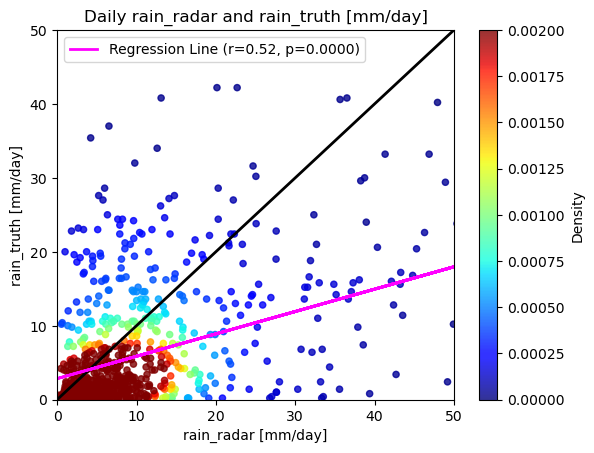

In [12]:
density_plot(df_['rain_truth'],df_['rr_SC_c1'])

RMSE: 13.3378798707139
MSE: 177.89903944559506
MAE: 7.030617348051408
R-squared: 0.17751898201742344
Correlation coefficient (r): 0.527727598962599
P-value: 5.160611960806133e-70


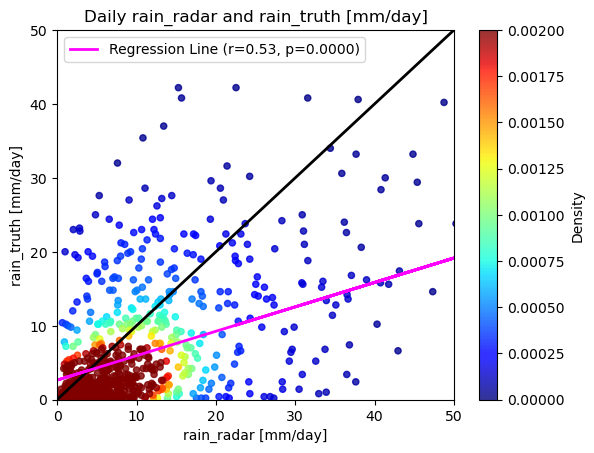

In [13]:
density_plot(df_['rain_truth'],df_['rr_SC_c2'])

RMSE: 12.479518888859191
MSE: 155.73839169739335
MAE: 6.775962195846404
R-squared: 0.20923407069627764
Correlation coefficient (r): 0.5603949745276254
P-value: 1.465362383338325e-80


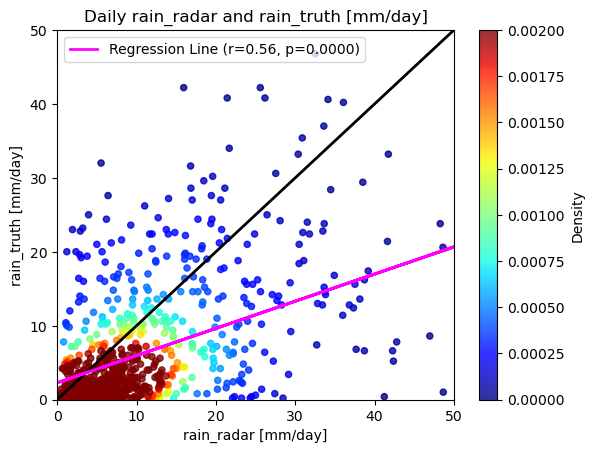

In [14]:
density_plot(df_['rain_truth'],df_['rr_SC_c3'])

RMSE: 13.42901897713444
MSE: 180.33855068823692
MAE: 6.970566979595529
R-squared: 0.12994468574924378
Correlation coefficient (r): 0.48522469473806124
P-value: 6.584915919509584e-58


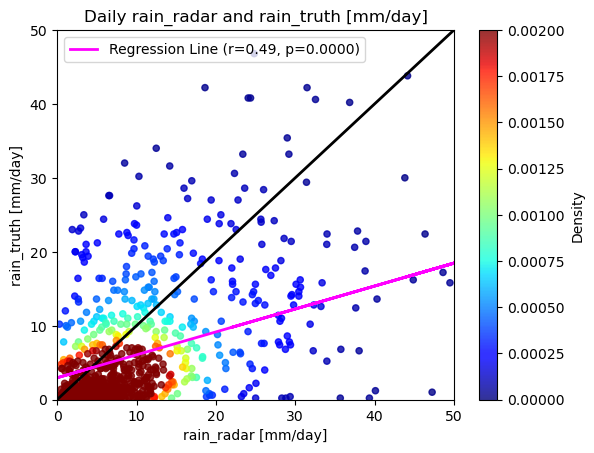

In [15]:
density_plot(df_['rain_truth'],df_['rr_SC_c4'])

### คำนวณสถิติ และ พลอตค่า metrics

In [16]:
def density_plot_joint(rain_truth,rain_radar):
    # data
    x = rain_radar
    y = rain_truth

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(x, y))
    mse = mean_squared_error(x, y)
    mae = mean_absolute_error(x, y)
    r2 = r2_score(x, y)

    # Calculate p-value and correlation coefficient (r)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Print results
    print(f'RMSE: {rmse}')
    print(f'MSE: {mse}')
    print(f'MAE: {mae}')
    print(f'R-squared: {r2}')
    print(f'Correlation coefficient (r): {r_value}')
    print(f'P-value: {p_value}')

    # Calculate the point density
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    
    # Set the desired colorbar range
    cbar_min = 0  # specify your minimum value
    cbar_max = 0.002  # specify your maximum value

    # Create a joint plot with scatter plot, regression line, and density plot
    sns.set(style="whitegrid")
    g = sns.jointplot(x=x, y=y, kind="reg", height=7)
    plt.plot(x, slope * x + intercept, linestyle='-', color='magenta', linewidth=2,
             label=f'Regression Line (r={r_value:.2f}, p={p_value:.4f})')
    #plt.text(0.5, 0.9, f'r = {r_value:.2f}, p = {p_value:.4f}', horizontalalignment='center', verticalalignment='center', transform=g.ax_joint.transAxes)

    # Add scatter plot with density color map
    scatter = plt.scatter(x, y, c=z, s=20, cmap='jet', alpha=0.8, vmin=cbar_min, vmax=cbar_max)
    
    # Set scatter plot aspect ratio to be equal
    #plt.gca().set_aspect('equal', adjustable='box')
    
    max_=50

    # Set x and y axis limits
    plt.xlim(0, max_)
    plt.ylim(0, max_)

    # Plot the 1:1 line
    plt.plot([0, max_], [0, max_], linestyle='-', color='black', linewidth=2)

    plt.xlabel('rain_radar [mm/day]')
    plt.ylabel('rain_truth [mm/day]')
    plt.title('Daily rain_radar and rain_truth [mm/day]')

    # Add colorbar using the scatter variable
    cbar = plt.colorbar(scatter)
    cbar.set_label('Density')

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Display the plot
    plt.show()


RMSE: 14.405245220385764
MSE: 207.5110898594469
MAE: 7.574448452223975
R-squared: 0.18244608197886325
Correlation coefficient (r): 0.5236789146718513
P-value: 8.730415426165672e-69


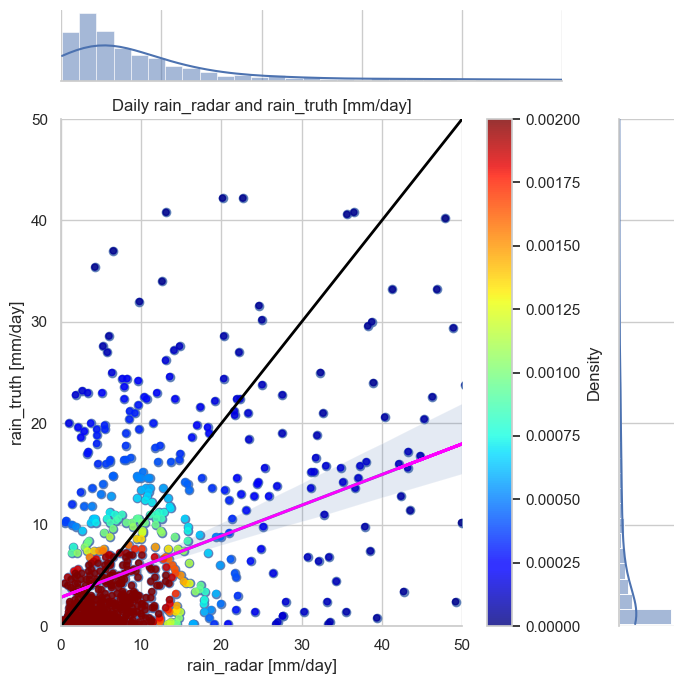

In [17]:
density_plot_joint(df_['rain_truth'],df_['rr_SC_c1'])

RMSE: 13.3378798707139
MSE: 177.89903944559506
MAE: 7.0306173480514085
R-squared: 0.17751898201742344
Correlation coefficient (r): 0.5277275989625976
P-value: 5.1606119608114296e-70


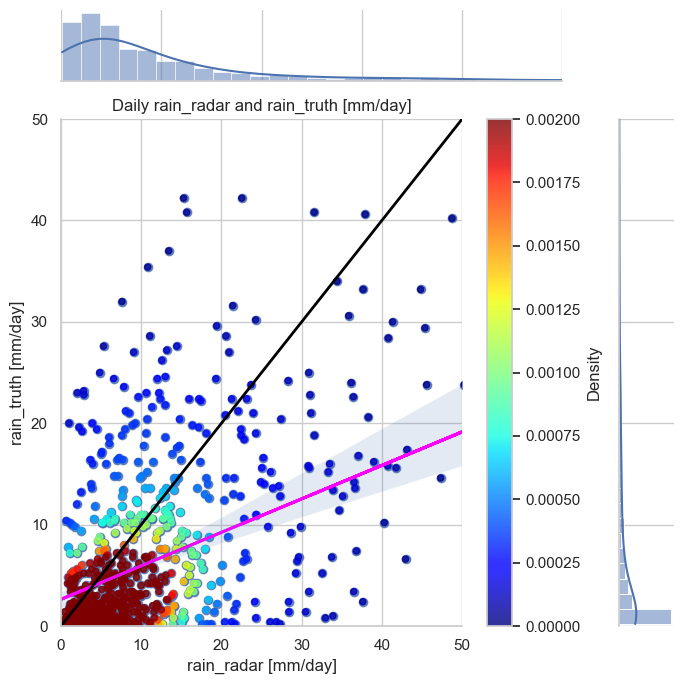

In [18]:
density_plot_joint(df_['rain_truth'],df_['rr_SC_c2'])

RMSE: 12.479518888859191
MSE: 155.73839169739335
MAE: 6.775962195846404
R-squared: 0.20923407069627764
Correlation coefficient (r): 0.5603949745276233
P-value: 1.4653623833407038e-80


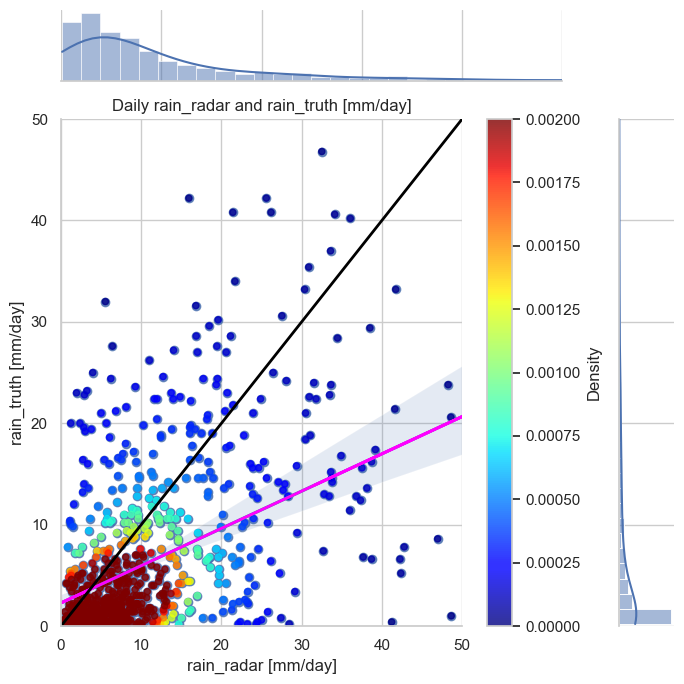

In [19]:
density_plot_joint(df_['rain_truth'],df_['rr_SC_c3'])

RMSE: 13.42901897713444
MSE: 180.33855068823692
MAE: 6.970566979595529
R-squared: 0.12994468574924378
Correlation coefficient (r): 0.48522469473806007
P-value: 6.584915919514656e-58


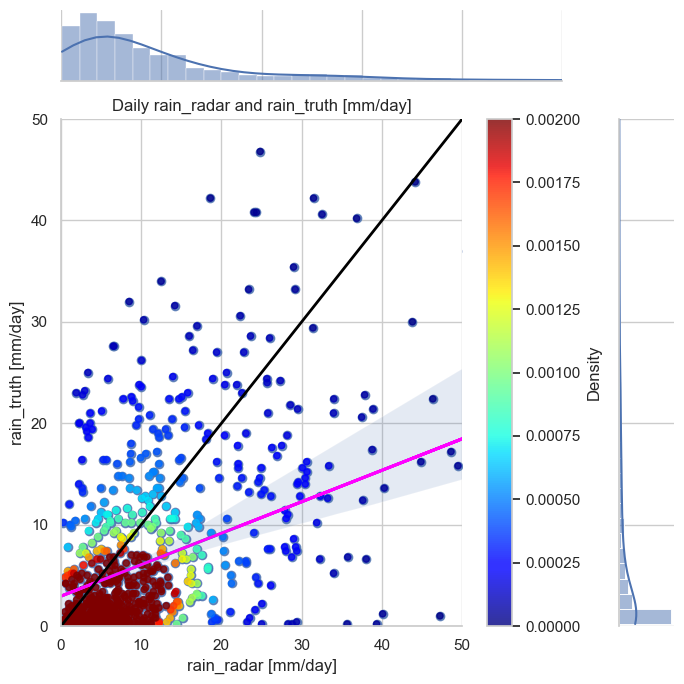

In [20]:
density_plot_joint(df_['rain_truth'],df_['rr_SC_c4'])

## รวมฝนรายวันเป็นฝนทั้งเหตุการณ์ของแต่ละสถานี

In [21]:
def density_plot_joint_events(rain_truth,rain_radar):
    # data
    x = rain_radar
    y = rain_truth

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(x, y))
    mse = mean_squared_error(x, y)
    mae = mean_absolute_error(x, y)
    r2 = r2_score(x, y)

    # Calculate p-value and correlation coefficient (r)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Print results
    print(f'RMSE: {rmse}')
    print(f'MSE: {mse}')
    print(f'MAE: {mae}')
    print(f'R-squared: {r2}')
    print(f'Correlation coefficient (r): {r_value}')
    print(f'P-value: {p_value}')

    # Calculate the point density
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    
    # Set the desired colorbar range
    cbar_min = 0  # specify your minimum value
    cbar_max = 0.002  # specify your maximum value

    # Create a joint plot with scatter plot, regression line, and density plot
    sns.set(style="whitegrid")
    g = sns.jointplot(x=x, y=y, kind="reg", height=7)
    plt.plot(x, slope * x + intercept, linestyle='-', color='magenta', linewidth=2,
             label=f'Regression Line (r={r_value:.2f}, p={p_value:.4f})')
    #plt.text(0.5, 0.9, f'r = {r_value:.2f}, p = {p_value:.4f}', horizontalalignment='center', verticalalignment='center', transform=g.ax_joint.transAxes)

    # Add scatter plot with density color map
    scatter = plt.scatter(x, y, c=z, s=10, cmap='jet', alpha=0.8, vmin=cbar_min, vmax=cbar_max)
    
    # Set scatter plot aspect ratio to be equal
    #plt.gca().set_aspect('equal', adjustable='box')

    # Set x and y axis limits
    max_=50
    plt.xlim(0, max_)
    plt.ylim(0, max_)

    # Plot the 1:1 line
    plt.plot([0, max_], [0, max_], linestyle='-', color='black', linewidth=2)

    plt.xlabel('rain_radar [mm]')
    plt.ylabel('rain_truth [mm]')
    plt.title('Events rain_radar and rain_truth [mm]')

    # Add colorbar using the scatter variable
    cbar = plt.colorbar(scatter)
    cbar.set_label('Density')

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Display the plot
    plt.show()

In [22]:
df_

,date_only,code,rain_truth,rr_SC_c1,rr_SC_c2,rr_SC_c3,rr_SC_c4
0,2018-06-01,BPPS,0.2,1.403455,1.202593,1.352917,1.691518
1,2018-06-01,CMSG,4.8,13.831574,12.498505,12.274215,13.338449
2,2018-06-01,KGKG,0.4,3.143708,3.366447,3.862913,3.715591
3,2018-06-01,KGLN,0.2,8.745856,8.620702,8.085142,9.101632
4,2018-06-01,KOKO,19.4,4.461450,7.987670,13.802062,11.469609
...,...,...,...,...,...,...,...
956,2018-09-20,TGSK,1.0,2.965246,3.285875,3.909733,4.180084
957,2018-09-20,TSLM,1.0,1.224675,1.217667,1.199010,1.105823
958,2018-09-20,VLGE15,0.4,1.997138,1.909545,1.809472,1.700514
959,2018-09-21,CNDN,0.2,1.313790,1.298414,1.253247,1.135267


In [23]:
import pandas as pd

# Assuming df_ is your DataFrame
# Group by 'code' and calculate the mean for each group
aggregated_df = df_.groupby('code').mean().reset_index()

# Display the aggregated DataFrame
print("Aggregated DataFrame:")
df_=aggregated_df
print(df_)


Aggregated DataFrame:
      code  rain_truth   rr_SC_c1   rr_SC_c2   rr_SC_c3   rr_SC_c4
0     BDLH    6.684211   7.457286   6.409124   6.449113   5.829062
1     BMNK    1.000000   4.342331   2.988243   4.540975   3.021229
2     BPPS    5.626667  12.178299  10.931354  10.061518   9.345594
3     CMSG    6.500000  14.199067  12.812664  10.653319   9.196186
4     CNDN   11.982609  21.206793  16.330698  14.770470  13.131017
..     ...         ...        ...        ...        ...        ...
63    WSPN    4.608696   6.222426   7.677072   7.583284   7.906519
64  YOM005    5.400000  19.568264  18.858807  17.500088  16.785820
65  YOM006    4.323077   7.009216   6.573350   7.844467   7.789727
66  YOM009    6.740000  12.690852  11.411485  10.790188  11.120137
67  YOM012    0.400000   3.843640   2.857364   3.626224   3.993634

[68 rows x 6 columns]


In [24]:
df_.corr()

,rain_truth,rr_SC_c1,rr_SC_c2,rr_SC_c3,rr_SC_c4
rain_truth,1.000000,0.463790,0.376258,0.384056,0.381140
rr_SC_c1,0.463790,1.000000,0.865501,0.715300,0.619654
rr_SC_c2,0.376258,0.865501,1.000000,0.940105,0.836371
rr_SC_c3,0.384056,0.715300,0.940105,1.000000,0.948951
rr_SC_c4,0.381140,0.619654,0.836371,0.948951,1.000000


RMSE: 7.793576337786304
MSE: 60.73983213290258
MAE: 5.832683051453031
R-squared: -0.48506991098429286
Correlation coefficient (r): 0.4637898938806307
P-value: 6.795243974744607e-05


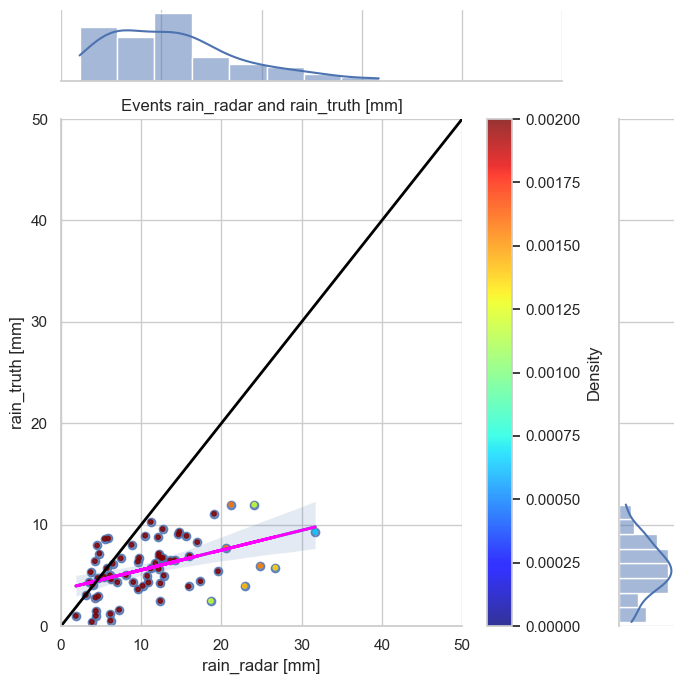

In [25]:
density_plot_joint_events(df_['rain_truth'],df_['rr_SC_c1'])

RMSE: 8.426533944458651
MSE: 71.00647431711388
MAE: 5.594993355719039
R-squared: -0.4246717457399998
Correlation coefficient (r): 0.37625798924274884
P-value: 0.0015655284068670568


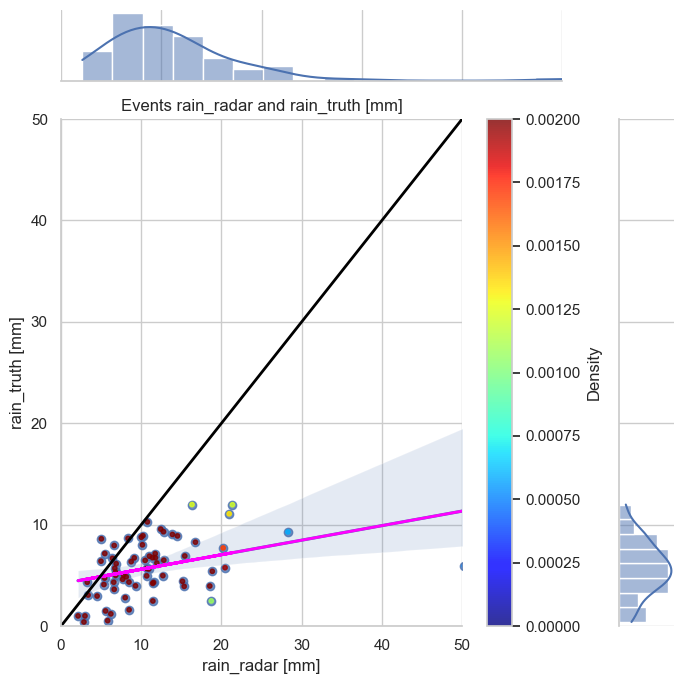

In [26]:
density_plot_joint_events(df_['rain_truth'],df_['rr_SC_c2'])

RMSE: 8.252659426352613
MSE: 68.10638760736664
MAE: 5.370493740517547
R-squared: -0.3806963989121732
Correlation coefficient (r): 0.3840560436339216
P-value: 0.0012238962986419676


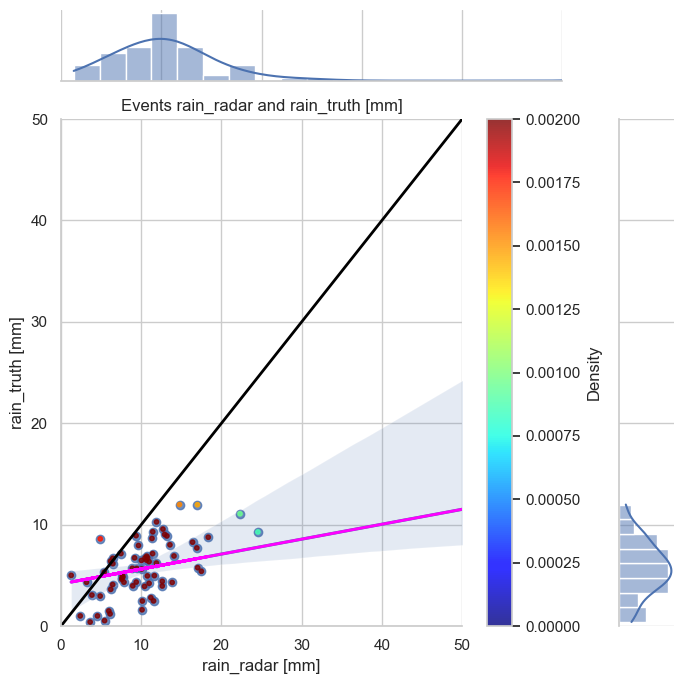

In [27]:
density_plot_joint_events(df_['rain_truth'],df_['rr_SC_c3'])

RMSE: 7.478157731093063
MSE: 55.922843051106945
MAE: 4.868227481204592
R-squared: -0.3926083841671957
Correlation coefficient (r): 0.38114029523071874
P-value: 0.0013428485488919248


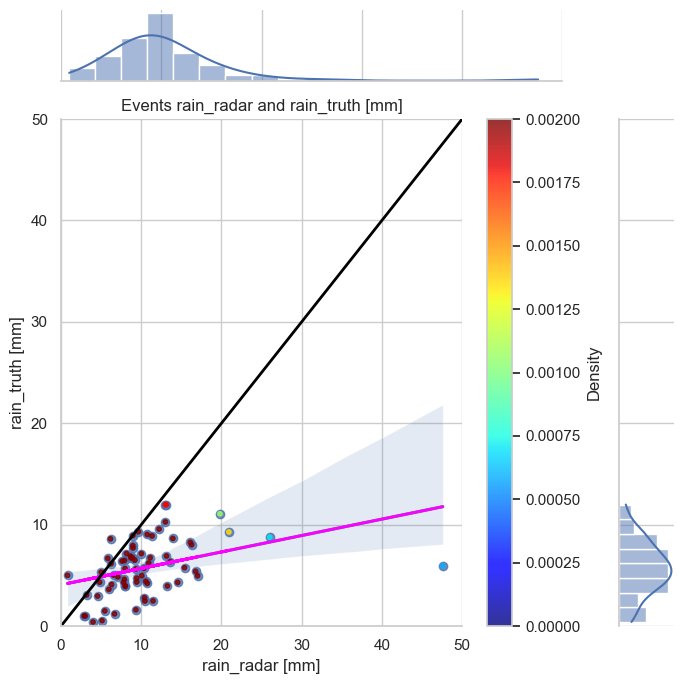

In [28]:
density_plot_joint_events(df_['rain_truth'],df_['rr_SC_c4'])

## หา bias และปรับแก้แบบ MFB Mean Field Bias Correction

In [29]:
MFB=df_['rr_SC_c1'].mean()/df_['rain_truth'].mean()
MFB     
#ต้องนำ MFB ไปปรับแก้ค่าฝน validate / testing

1.928856946964847

In [30]:
# ทดสอบปรับแก้ MFB ด้วยการคูณเข้ากับฝนประมาณค่าจากเรดาร์
df_['corrected_rr_SC_c1']=df_['rr_SC_c1']*(1/MFB)

In [31]:
df_.head()

,code,rain_truth,rr_SC_c1,rr_SC_c2,rr_SC_c3,rr_SC_c4,corrected_rr_SC_c1
0,BDLH,6.684211,7.457286,6.409124,6.449113,5.829062,3.866169
1,BMNK,1.000000,4.342331,2.988243,4.540975,3.021229,2.251246
2,BPPS,5.626667,12.178299,10.931354,10.061518,9.345594,6.313739
3,CMSG,6.500000,14.199067,12.812664,10.653319,9.196186,7.361389
4,CNDN,11.982609,21.206793,16.330698,14.770470,13.131017,10.994487


In [32]:
df_.corr()

,rain_truth,rr_SC_c1,rr_SC_c2,rr_SC_c3,rr_SC_c4,corrected_rr_SC_c1
rain_truth,1.000000,0.463790,0.376258,0.384056,0.381140,0.463790
rr_SC_c1,0.463790,1.000000,0.865501,0.715300,0.619654,1.000000
rr_SC_c2,0.376258,0.865501,1.000000,0.940105,0.836371,0.865501
rr_SC_c3,0.384056,0.715300,0.940105,1.000000,0.948951,0.715300
rr_SC_c4,0.381140,0.619654,0.836371,0.948951,1.000000,0.619654
corrected_rr_SC_c1,0.463790,1.000000,0.865501,0.715300,0.619654,1.000000


RMSE: 7.793576337786304
MSE: 60.73983213290258
MAE: 5.832683051453031
R-squared: -0.48506991098429286
Correlation coefficient (r): 0.4637898938806307
P-value: 6.795243974744607e-05


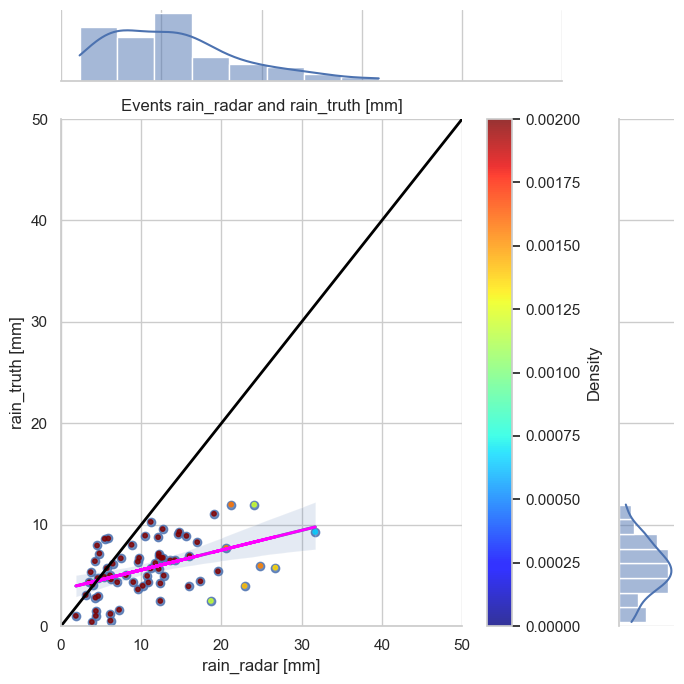

In [33]:
# ก่อนปรับแก้ MFB
density_plot_joint_events(df_['rain_truth'],df_['rr_SC_c1'])

RMSE: 3.155514430459202
MSE: 9.957271320836263
MAE: 2.408168725852255
R-squared: 0.09423884394958348
Correlation coefficient (r): 0.46378989388063074
P-value: 6.795243974744588e-05


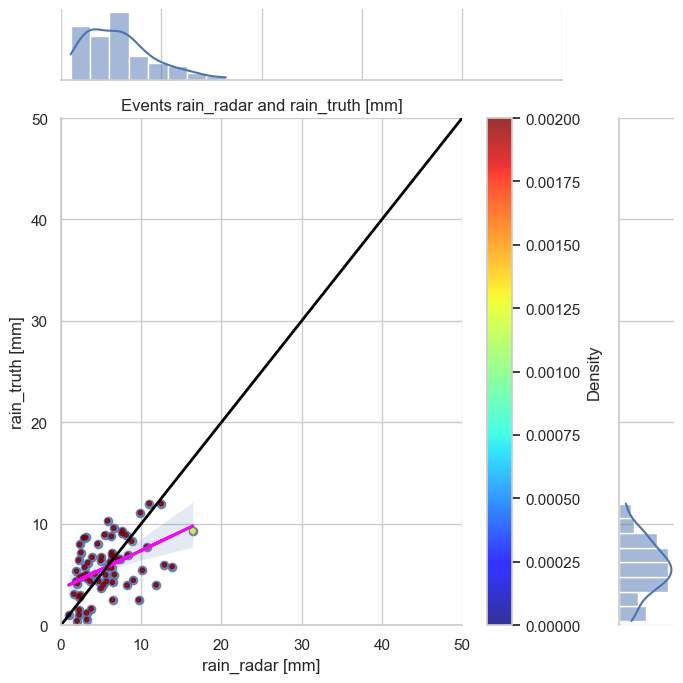

In [34]:
# หลังปรับแก้ MFB
density_plot_joint_events(df_['rain_truth'],df_['corrected_rr_SC_c1'])